# MORE Plot for hospital reception simulation using plotnine
Louis Luangkesorn lluangkesorn@pitt.edu
8/15/2019

This introduces the Measure of Risk and Error (MORE) plot [Nelson08] of simulation output which simultaneously shows the analyst a sense of the risk, expressed as a histogram along with the mean, the 0.05 quantile, and the 0.95 quantile), and a sense of the error of the simulation output (expressed as 95% C.I. for the mean, the 0.05 quantile, and the 0.95 quantile).

This example uses a hospital receptionist simulation orginally found in [Nelson13]. The implementation of the simulation uses the Simpy library in Python [simmer19]

Nelson08: Nelson, B., (2008), THE MORE PLOT: DISPLAYING MEASURES OF RISK & ERROR FROM SIMULATION OUTPUT, 2008 Winter Simulation Conference, https://www.informs-sim.org/wsc08papers/048.pdf

Nelson13: Nelson, B., (2013), Foundations and Methods of Stochastic Simulation, Springer, http://users.iems.northwestern.edu/~nelsonb/IEMS435/

Simpy19: Stefan Scherfke and Ontje Lünsdorf (2019). Simpy: Discrete Event Simulation for Python, https://simpy.readthedocs.io/en/latest/contents.html

In [1]:
# Hospital reception discrete event simulation with 
# MORE Plot
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import expon, erlang
import pandas as pd
import simpy
import plotnine as p9

def source(env, interval, receptionist):
    i = 0
    while True:
        i += 1
        c = patient(env, 'patient%02d' % i, receptionist, time_service=12.0)
        env.process(c)
        t = expon.rvs(0, 1.0/G.ARRint, size=1)
        yield env.timeout(t)


def patient(env, name, receptionist, time_service):
    arrive = env.now
    with receptionist.request() as req:
        yield req
        timenow = env.now
        wait = timenow - arrive
        env.arrival.append(timenow)
        env.waittime.append(wait)
        tis = erlang.rvs(G.phases,
                         scale=float(G.timeReceptionist)/G.phases, size=1)
        yield env.timeout(tis)
    return


#  Experiment data -------------------------
class G:
    RANDOM_SEED = 42
    INTERVAL_patientS = 10.0  # Generate new patients roughly every x seconds
    maxTime = 8 * 60         # minutes
    timeReceptionist = 0.8  # mean, minutes
    phases = 3
    ARRint = 1.0            # mean, minutes
    theseed = 99999


class HospitalSim(object):
    def run(self, aseed):
        print('Hospital simulation')
        sp.random.seed(aseed)
        env = simpy.Environment()
        env.arrival = []
        env.waittime = []
        receptionist = simpy.Resource(env, capacity=1)
        env.process(source(env, G.INTERVAL_patientS, receptionist))
        env.run(until=G.maxTime)
        return env



In [2]:
reps = 10
hospital = HospitalSim()
arrivallist = []
waittimelist = []
for i in range(reps):
    results = hospital.run(G.RANDOM_SEED+i)
    arrivallist.append([float(x) for x in results.arrival])
    waittimelist.append([float(x) for x in results.waittime])



Hospital simulation
Hospital simulation
Hospital simulation
Hospital simulation
Hospital simulation
Hospital simulation
Hospital simulation
Hospital simulation
Hospital simulation
Hospital simulation


In [3]:
# Combine all observations into a single list for the overall histogram
# Identify performance measure to make this generic
observationlist = waittimelist
observationname = 'Flow time'
allwaits = [item for sublist in observationlist for item in sublist]
allwaitsdf = pd.DataFrame({'observation':allwaits})

In [4]:
flowplot = (p9.ggplot(allwaitsdf) + 
    p9.geom_histogram(p9.aes(x='observation', y='stat(density)')))

In [5]:
# Generate means and quantiles for each replication
meanwaits = [sp.mean(observation) for observation in observationlist]
q05waits = [sp.quantile(observation, q=0.05) for observation in observationlist]
q95waits = [sp.quantile(observation, q=0.95) for observation in observationlist]
meanstats = pd.DataFrame({'mean':[sp.mean(meanwaits)],
                           'lowerci': [sp.stats.t.ppf(0.05,df=reps) * sp.std(meanwaits)/len(meanwaits) + 
                                      sp.mean(meanwaits)],
                           'upperci': [sp.stats.t.ppf(0.95,df=reps) * sp.std(meanwaits)/len(meanwaits) + 
                                      sp.mean(meanwaits)]})
q05stats = pd.DataFrame({'mean':[sp.mean(q05waits)],
                           'lowerci': [sp.stats.t.ppf(0.05,df=reps) * sp.std(q05waits)/len(q05waits) + 
                                      sp.mean(q05waits)],
                           'upperci': [sp.stats.t.ppf(0.95,df=reps) * sp.std(q05waits)/len(q05waits) + 
                                      sp.mean(q05waits)]})
q95stats = pd.DataFrame({'mean':[sp.mean(q95waits)],
                           'lowerci': [sp.stats.t.ppf(0.05,df=reps) * sp.std(q95waits)/len(q95waits) + 
                                      sp.mean(q95waits)],
                           'upperci': [sp.stats.t.ppf(0.95,df=reps) * sp.std(q95waits)/len(q95waits) + 
                                      sp.mean(q95waits)]})

In [6]:
print(meanstats)
print(q05stats)
print(q95stats)

       mean   lowerci   upperci
0  1.910982  1.875531  1.946433
   mean  lowerci  upperci
0   0.0      0.0      0.0
       mean   lowerci   upperci
0  6.156729  6.010746  6.302711


# Measures of Risk and Error

## Risk vs. Error
    - Measures of risk
        -  Directly support decision making.
        -  What is the range of outcomes that can occur and their probabilities if the system is designed in a specific way.
        -  If $F_Y(5)$ (probability of completing a project in 5 days) is too small, we may decide not to undertake the project as designed.
    -  Measures of error
    -  Directly support experiment design
    -  Did we expend enough simulation effort (e.g. replications) to be confident in our estimates of system performance

## Measure of Risk and Error (MORE) Plot

- Measures of error. The C.I. on the average or the quantiles are measure of error.
    - As a simulation analyst we can reduce error (how?)
    - How to choose which performance measure's C.I. we should use in specifying error.
    -  What does the C.I. on these statistics (average, quantile) tell us about our system and experimental design?
- Measures of risk
    -  How can we as engineers reduce risk?
    -  How do we measure risk? What do these types of statistics actually tell us about our system and experimental design?
    
## Creating a MORE plot
-  Start with a histogram.
-  Add the sample average and 0.05 and 0.95 quantiles.
    -  This range is considered likely, beyond that is considered unlikely.
-  Measure of risk
    -  Include 95% C.I. for the average and both quantiles.
    -  Measure of error at the center and the extremes of the range of outcomes.
-  Goal: to represent both risk and error in an intuitively understandable way.

C:\Users\louis\Anaconda3\lib\site-packages\plotnine\layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
C:\Users\louis\Anaconda3\lib\site-packages\plotnine\layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
C:\Users\louis\Anaconda3\lib\site-packages\plotnine\layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
C:\Users\louis\Anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: UserWarning: 'stat_bin()' using 'bins = 39'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']))


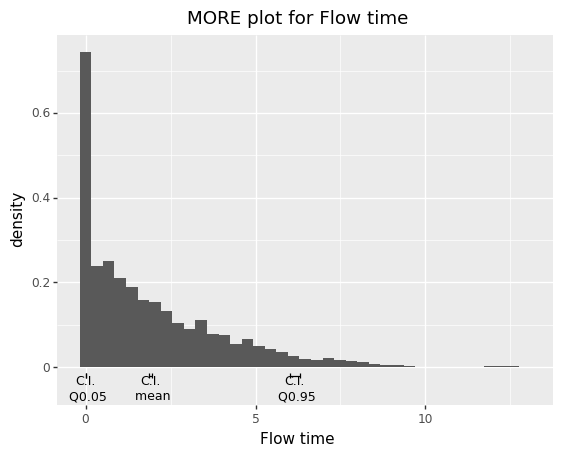

<ggplot: (124192130196)>

In [7]:
(flowplot + 
    p9.geom_errorbarh(data = meanstats, mapping=p9.aes(xmax = 'upperci', xmin = 'lowerci', 
                                         y = -0.02), height = 0.01) +
    p9.geom_errorbarh(data = q05stats, mapping=p9.aes(xmax = 'upperci', xmin = 'lowerci', 
                                        y = -0.02), height = 0.01) +
    p9.geom_errorbarh(data = q95stats, mapping=p9.aes(xmax = 'upperci', xmin = 'lowerci', 
                                        y = -0.02), height = 0.01) +
    p9.annotate("text", label = "C.I.\n mean", x = (meanstats['mean']), y = -0.05, size = 9) +
    p9.annotate("text", label = "C.I.\n Q0.05", x = q05stats['mean'], y = -0.05, size = 9) +
    p9.annotate("text", label = "C.I.\n Q0.95", x = q95stats['mean'], y = -0.05, size = 9) +
    p9.ggtitle("MORE plot for " + observationname) +
    p9.xlab(observationname)

)

In this MORE plot, the error bars below the x-axis represent the 95% C.I. of the mean and 0.05 and 0.95 quantiles. The mean and quantiles provides a measure of the risk, what is the range of values that will generally be experienced by entities in this system (visitors to a hospital going to the information desk). The error bars provide measures of the error, which are the confidence intervals of the estimate of the mean, the 0.05 quantile, and the 0.95 quantile. Note that the measure of error is not the same for each of the three. Depending on what performance measure is most useful for the system, the analyst would then decide how many replications would be needed to reduce that particular performance measure's C.I. to an acceptable level.